In [1]:
import os
os.chdir('./Justcode/deeplearning-study/1-3/')
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from testCases import *
from planar_utils import *

np.random.seed(1)

In [2]:
X, Y = load_planar_dataset()
print(f'X.shape = {X.shape}')
print(f'Y.shape = {Y.shape}')

X.shape = (2, 400)
Y.shape = (1, 400)


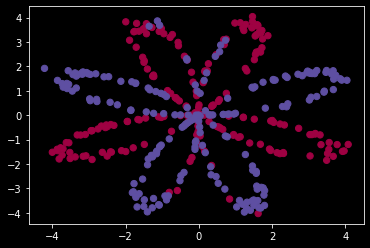

In [3]:
plt.scatter(X[0], X[1], s=40, c=np.squeeze(Y), cmap=plt.cm.Spectral)

F:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\ProgramFiles\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


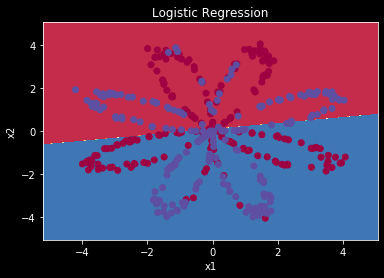

In [4]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, Y.T)
plot_decision_boundary(clf.predict, X, Y)
plt.title('Logistic Regression')
plt.show()

In [5]:
print('逻辑回归准确率', clf.score(X.T, Y.T))
X = X / 5

逻辑回归准确率 0.47


In [6]:
def tanh(x):
    s = np.tanh(x)
    return s

def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

def ReLU(x):
    s = max(0, x)
    return s



class Layer(object):


    def __init__(self, n_input, n_layer, activate, name=None):
        self.n = n_layer
        self.name = name
        self.activate = activate
        self.X = None
        self.W = np.random.randn(n_layer, n_input) + 10e-4
        self.b = np.zeros((n_layer, 1))
        self.Z = None
        self.A = None
        self.dA = None
        self.dZ = None
        self.dW = None
        self.db = None
        self.dX = None

    def get_W(self):
        return self.W

    def get_b(self):
        return self.b

    def get_A(self):
        return self.A

    def get_dX(self):
        return self.dX    

    def fwprop(self, X):
        self.X = X
        self.Z = np.dot(self.W, self.X) + self.b
        self.A = self.activate(self.Z)

    def bkprop(self, dA, alpha):
        self.dA = dA
        if self.activate == tanh:
            self.dZ = self.dA * (1 - self.A**2)
        elif self.activate == sigmoid:
            self.dZ = self.dA * self.A * (1 - self.A)
        elif self.activate == ReLU:
            self.dZ = self.dA * (self.A > 0)
        else:
            print('Wrong activate function!')
        self.dX = np.dot(self.W.T, self.dZ)
        self.dW = np.dot(self.dZ, self.X.T)
        self.db = np.mean(self.dZ, axis=1).reshape((self.n, 1))
        # print('db.shape', self.db.shape)
        self.W -= alpha * self.dW
        self.b -= alpha * self.db



class Model(object):


    def __init__(self, X_train, Y_train, alpha=0.005, loops=2000):
        self.X = X_train
        self.Y = Y_train
        self.alpha = alpha
        self.loops = loops
        self.L = 0
        self.layers = []
        self.layers_reverse = []
        self.A = None
        self.J = None
        self.J_list = []

    def add_layer(self, n_input, n_layer, activate, name=None):
        self.L += 1
        new_layer = Layer(n_input, n_layer, activate, name=name)
        self.layers.append(new_layer)
        self.layers_reverse = self.layers.copy()
        self.layers_reverse.reverse()
        # print(self.layers)
        # print(self.layers_reverse)
        return new_layer

    def fwprop(self):
        input_ = self.X
        # print(self.layers)
        # print('input_\n', input_)
        for layer in self.layers:
            layer.fwprop(input_)
            input_ = layer.get_A()

    def compute_J(self):
        self.A = self.layers[-1].get_A()
        # print('model.A\n', self.A)
        self.J = np.mean((-self.Y * np.log(self.A) - (1 - self.Y) * np.log(1 - self.A)), axis=1).sum()
        # print('model.J\n', self.J)

    def bkprop(self):
        dA = -self.Y / self.A + (1 - self.Y) / (1 - self.A)
        # print('model.dA\n', dA)
        # print(self.layers_reverse)
        for layer in self.layers_reverse:
            layer.bkprop(dA, alpha=self.alpha)
            dA = layer.get_dX()
            # print('dA\n', dA)

    def train(self):
        for i in range(self.loops):
            self.fwprop()
            self.compute_J()
            self.bkprop()
            j = i + 1
            if j%50 == 0:
                self.J_list.append(self.J)
                print(f'第{j}次迭代的损失值: {self.J}')

    def predict(self, X_test):
        for layer in self.layers:
            layer.fwprop(X_test)
            X_test = layer.get_A()
        Y_predict = X_test
        return Y_predict

    def score(self, X_test, Y_test):
        #仅实现二分类问题
        Y_predict = self.predict(X_test)
        result = (Y_predict > 0.5) == Y_test
        print('Y_predict\n', Y_predict)
        acc = result.mean()
        return acc

    def plot_loss(self):
        plt.plot(self.J_list)
        plt.xlabel('steps per 50')
        plt.ylabel('loss')
        plt.title('loss circle')
        plt.show()

    def plot_bound(self):
        plot_decision_boundary(lambda x: self.predict(x.T), self.X, self.Y)
        plt.title('Neual Network Decision Boundary')
        plt.show()

In [7]:
model = Model(X, Y, alpha=0.005, loops=2000)
layer1 = model.add_layer(2, 4, tanh, name='Hidden Layer')
layer2 = model.add_layer(4, 1, sigmoid, name='Output Layer')
model.train()

F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in log
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in multiply
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in true_divide
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
F:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in multiply
第50次迭代的损失值: nan
第100次迭代的损失值: nan
第150次迭代的损失值: nan
第200次迭代的损失值: nan
第250次迭代的损失值: nan
第300次迭代的损失值: nan
第350次迭代的损失值: nan
第400次迭代的损失值: nan
第450次迭代的损失值: nan
第500次迭代的损失值: nan
第550次迭代的损失值: nan
第600次迭代的损失值: nan
第650次迭代的损失值: nan
第700次迭代的损失值: nan
第750次迭代的损失值: nan
第800次迭代的损失值: nan
第850次迭代的损失值: nan
第900次迭代的损失值: nan
第950次迭代的损失值: nan
第1000次迭代的损失值: nan
第1050次迭代的损失值: nan
第1100次迭代的损失值: n

In [8]:
accuracy = model.score(X, Y)
print(accuracy)

Y_predict
 [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan n

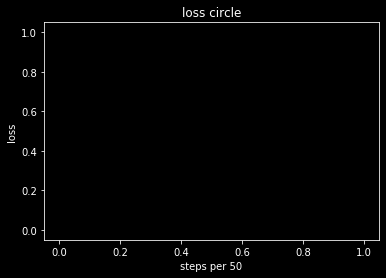

In [9]:
model.plot_loss()

F:\ProgramFiles\Anaconda3\lib\site-packages\matplotlib\contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
F:\ProgramFiles\Anaconda3\lib\site-packages\matplotlib\contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
F:\ProgramFiles\Anaconda3\lib\site-packages\matplotlib\contour.py:1169: RuntimeWarning: invalid value encountered in less
  under = np.nonzero(lev < self.zmin)[0]
F:\ProgramFiles\Anaconda3\lib\site-packages\matplotlib\contour.py:1171: RuntimeWarning: invalid value encountered in greater
  over = np.nonzero(lev > self.zmax)[0]


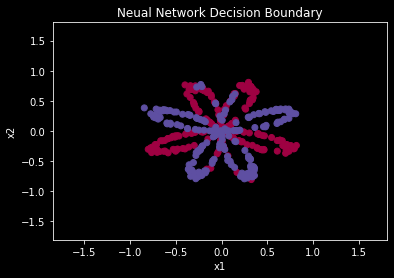

In [10]:
model.plot_bound()

In [11]:
print('layer1:', model.layers[0].name)
print('layer2:', model.layers[1].name)

layer1: Hidden Layer
layer2: Output Layer
